# Welcome to PsyNeuLink

PsyNeuLink is an integrated language and toolkit for creating cognitive models. It decreases the overhead required for cognitive modeling by providing standard building blocks (DDMS, Neural Nets, etc.) and the means to connect them together in a single environment. PsyNeuLink is designed to make the user think about computation in a "mind/brain-like" way while imposing minimal constraint on the type of models that can be implemented.

## How to get PsyNeuLink

Right now, PsyNeuLink is in an alpha state and is not available through pypi/pip. Instead, you can clone the github repo [here](https://github.com/PrincetonUniversity/PsyNeuLink). For now, clone the devel branch rather than the master branch. You can switch branches by pressing the "branch: master" dropdown menu on the left side of the page. Then download the package with the green "Clone or download" button on the right side of the page and "Download ZIP." Open the version of this Tutorial in the cloned folder before continuing on.

Alternatively, if you are familiar with git, the directory can be cloned as usual through the terminal.
Note: The repo is currently private, so if the link leads to a dead page, reach out to one of the developers to get acccess.

## Prerequisites

PsyNeuLink is compatible with any version of python 3, but this tutorial requires a 3.5 installation with the latest versions of IPython, jupyter, and matplotlib installed.

## Installation

To install the package, navigate to the cloned directory in a terminal, switch to your preferred python3 environment, then run the command __"pip install ."__ (make sure to include the period and to use the appropriate pip/pip3 command for python 3.5). All prerequisite packages will be automatically added to your enviroment.

For the curious, these are:
* numpy
* matplotlib
* toposort
* mpi4py
* typecheck-decorator


## Tutorial Overview

This tutorial is meant to get you accustomed to the structure of PsyNeuLink and be able to construct basic models. Starting with a simple 1-to-1 transformation, we will build up to making the Stroop model from Cohen et al. (1990). Let's get started!

### Imports and file structure

The following code block will import the necessary components for basic neural network models in PsyNeuLink. In particular, we need tools for handling *[systems](https://princetonuniversity.github.io/PsyNeuLink/System.html)*, *[processes](https://princetonuniversity.github.io/PsyNeuLink/Process.html)*, the set of specific *[mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* that will make up our networks, and the *[projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html)* to connect them. We also import basic prerequisites and set up the jupyter environment for visualization.

In [ ]:
from PsyNeuLink.Components.System import system

from PsyNeuLink.Components.Process import *

from PsyNeuLink.Components.Mechanisms.ProcessingMechanisms.TransferMechanism import TransferMechanism
from PsyNeuLink.Components.Functions.Function import Linear, Logistic

TypeError: Unions cannot be used with issubclass().

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

### Creating a mechanism

*[Mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* are the basic units of computation in PsyNeuLink. At their core is a parameterized *function* but they also contain the machinery to interact with input, output, control, and learning signals. Our first mechanism will perform a linear transformation on a scalar input. For now, we will initialize it by just specifying the *function* of the mechanism.

In [18]:
linear_transfer_mechanism = TransferMechanism(
    function=Linear(slope=1, intercept=0))

In this case, we didn't actually need to specify the slope and intercept as the function will default to reasonable values (in this case, 1 and 0 respectively).

In [20]:
linear_transfer_mechanism.execute([1])

array([[ 1.]])

Try reparamaterizing the mechanism and executing again before moving on.

### Organizing into Processes

Generally with PsyNeuLink, you won't be executing mechanisms as stand-alone entities. Rather, they will be encapsulated inside *[Processes](https://princetonuniversity.github.io/PsyNeuLink/Process.html)* and later *[Systems](https://princetonuniversity.github.io/PsyNeuLink/System.html)*. A process is a collection of mechanisms and projections to be executed serially. They may be thought of as a way to concatenate mechanisms into a single, more complex unit of analysis in order to simplify interacting with larger models.

The main parameter when initializing a process is its pathway, which is the order in which the mechanisms will execute. Of course, with only one mechanism in our process, the list has just one element.

To better see how the process runs, we also turn on output reporting. Reporting can happen at every level in PsyNeuLink so we set the preference for both the process and mechanism.

In [23]:
linear_transfer_process = process(pathway = [linear_transfer_mechanism])

# Note: Make sure you do not run this cell multiple times. This would create multiple
# processes that share the same variable name in the PsyNeuLink registry causing
# unexpected behavior.

linear_transfer_mechanism.reportOutputPref = True
linear_transfer_process.reportOutputPref = True

In [24]:
linear_transfer_process.execute([4])



****************************************


'Process-1' executing with:
- pathway: ['TransferMechanism-1']
- input: [[4]]

'TransferMechanism-1'  executed:
- input:  4.0
- params:
	function: Linear
		intercept: 0
		slope: 1
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.0

'Process-1' completed:
- output: 4.0


****************************************



array([ 4.])

Let's turn off the reporting and look at our process' output over a wider range of values.

---------------------------------------------------

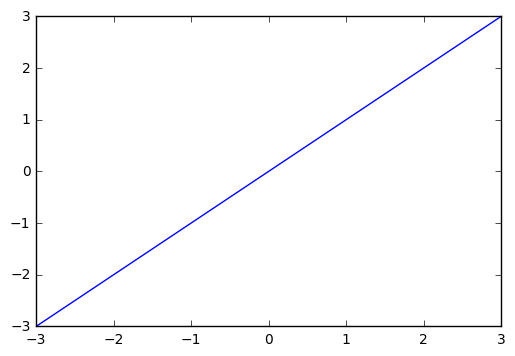

In [7]:
linear_transfer_mechanism.reportOutputPref = False
linear_transfer_process.reportOutputPref = False

xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = linear_transfer_process.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

Now let's put it all together and make a new transfer process, this time with a logistic activation function. We will also extend our mechanism by giving it two units (operating on a 1x2 matrix) rather than the default one (operating on a scalar).


'TransferMechanism-2'  executed:
- input:  -3.0, -6.0
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0474 0.00247
-
'TransferMechanism-2'  executed:
- input:  -2.88, -5.76
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0532 0.00314
-
'TransferMechanism-2'  executed:
- input:  -2.76, -5.52
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0595 0.00399
-
'TransferMechanism-2'  executed:
- input:  -2.64, -5.28
- params:
	function: Logistic
		bias: 0


		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0666 0.00507
-
'TransferMechanism-2'  executed:
- input:  -2.52, -5.04
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0745 0.00643
-
'TransferMechanism-2'  executed:
- input:  -2.4, -4.8
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0832 0.00816
-
'TransferMechanism-2'  executed:
- input:  -2.28, -4.56
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0928 0.0104
-
'TransferMechanism-2'  executed:
- input:  -2.16, -4.32
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.103 0.0131
-
'TransferMechanism-2'  executed:
- input:  -2.04, -4.08


- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.115 0.0166
-
'TransferMechanism-2'  executed:
- input:  -1.92, -3.84
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.128 0.021
-
'TransferMechanism-2'  executed:
- input:  -1.8, -3.6
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.142 0.0266
-
'TransferMechanism-2'  executed:
- input:  -1.68, -3.36
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.157 0.0336
-


'TransferMechanism-2'  executed:
- input:  -1.56, -3.12
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.174 0.0423
-
'TransferMechanism-2'  executed:
- input:  -1.44, -2.88
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.192 0.0532
-
'TransferMechanism-2'  executed:
- input:  -1.32, -2.64
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.211 0.0666
-
'TransferMechanism-2'  executed:
- input:  -1.2, -2.4
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.231 0.0832
-
'TransferMechanism-2'  executed:
- input:  -1.08, -2.16
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.254 0.103
-


'TransferMechanism-2'  executed:
- input:  -0.96, -1.92
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.277 0.128
-
'TransferMechanism-2'  executed:
- input:  -0.84, -1.68
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.302 0.157
-
'TransferMechanism-2'  executed:
- input:  -0.72, -1.44
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.327 0.192
-
'TransferMechanism-2'  executed:
- input:  -0.6, -1.2
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.354 0.231
-
'TransferMechanism-2'  executed:
- input:  -0.48, -0.96
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0


	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.382 0.277
-
'TransferMechanism-2'  executed:
- input:  -0.36, -0.72
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.411 0.327
-
'TransferMechanism-2'  executed:
- input:  -0.24, -0.48
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.44 0.382
-
'TransferMechanism-2'  executed:
- input:  -0.12, -0.24
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.47 0.44
-
'TransferMechanism-2'  executed:
- input:  0.0, 0.0
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.5 0.5
-
'TransferMechanism-2'  executed:
- input:  0.12, 0.24
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.53 0.

- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.56 0.618
-
'TransferMechanism-2'  executed:
- input:  0.36, 0.72
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.589 0.673
-


'TransferMechanism-2'  executed:
- input:  0.48, 0.96
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.618 0.723
-
'TransferMechanism-2'  executed:
- input:  0.6, 1.2
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.646 0.769
-


'TransferMechanism-2'  executed:
- input:  0.72, 1.44
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.673 0.808
-


'TransferMechanism-2'  executed:
- input:  0.84, 1.68
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.698 0.843
-
'TransferMechanism-2'  executed:
- input:  0.96, 1.92
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.723 0.872
-


'TransferMechanism-2'  executed:
- input:  1.08, 2.16
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.746 0.897
-


'TransferMechanism-2'  executed:
- input:  1.2, 2.4
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.769 0.917
-
'TransferMechanism-2'  executed:
- input:  1.32, 2.64
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL


- output: 0.789 0.933
-
'TransferMechanism-2'  executed:
- input:  1.44, 2.88
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.808 0.947
-
'TransferMechanism-2'  executed:
- input:  1.56, 3.12
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.826 0.958
-


'TransferMechanism-2'  executed:
- input:  1.68, 3.36
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.843 0.966
-
'TransferMechanism-2'  executed:
- input:  1.8, 3.6
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.858 0.973
-
'TransferMechanism-2'  executed:
- input:  1.92, 3.84
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.872 0.979
-


'TransferMechanism-2'  executed:
- input:  2.04, 4.08
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.885 0.983
-
'TransferMechanism-2'  executed:
- input:  2.16, 4.32
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.897 0.987
-
'TransferMechanism-2'  executed:
- input:  2.28, 4.56
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.907 0.99
-


'TransferMechanism-2'  executed:
- input:  2.4, 4.8
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.917 0.992
-


'TransferMechanism-2'  executed:
- input:  2.52, 5.04
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.926 0.994
-
'TransferMechanism-2'  executed:
- input:  2.64, 5.28
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.933 0.995
-


'TransferMechanism-2'  executed:
- input:  2.76, 5.52
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.94 0.996
-
'TransferMechanism-2'  executed:
- input:  2.88, 5.76
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.947 0.997
-


'TransferMechanism-2'  executed:
- input:  3.0, 6.0
- params:
	function: Logistic
		bias: 0
		gain: 1
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.953 0.998
-

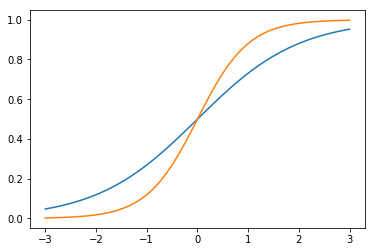

In [25]:
# Create the mechanism
logistic_transfer_mechanism = TransferMechanism(default_input_value=[0, 0],
                                                function=Logistic(gain=1,
                                                                  bias=0))

# Package into a process
logistic_transfer_process = process(pathway=[logistic_transfer_mechanism])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
y1Vals = np.zeros((51,))
y2Vals = np.zeros((51,))
for i in range(xVals.shape[0]):
    # clarify why multiplying times 2
    output = logistic_transfer_process.execute([xVals[i], xVals[i] * 2])
    y1Vals[i] = output[0]
    y2Vals[i] = output[1]
    # Progress bar
    print("-", end="")
plt.plot(xVals, y1Vals)
plt.plot(xVals, y2Vals)
plt.show()

The default_input_value parameter serves a dual function. It specifies the dimensionality of the mechanism as well as providing the inputs that will be given in the absence of explicit input at runtime.

### Adding Projections

To make more complex processes, we need a way to link mechanisms together. This is done through *[Projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html)*. A projection takes a mechanism output, multiplies it by the projection's mapping matrix, and delivers the transformed value to the next mechanism in the process.


'TransferMechanism-3'  executed:
- input:  -3.0
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -4.0

'TransferMechanism-4'  executed:
- input:  -4.0
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.018
-
'TransferMechanism-3'  executed:
- input:  -2.88
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.76

'TransferMechanism-4'  executed:
- input:  -3.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0228
-
'TransferMechanism-3'  executed:
- input:  -2.76
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.52

'TransferMechanism-4'  executed:
- input:  -3.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	


'TransferMechanism-3'  executed:
- input:  -2.64
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.28

'TransferMechanism-4'  executed:
- input:  -3.28
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0363
-
'TransferMechanism-3'  executed:
- input:  -2.52
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.04

'TransferMechanism-4'  executed:
- input:  -3.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0457
-


'TransferMechanism-3'  executed:
- input:  -2.4
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.8

'TransferMechanism-4'  executed:
- input:  -2.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0573
-
'TransferMechanism-3'  executed:
- input:  -2.28
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.56

'TransferMechanism-4'  executed:
- input:  -2.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0718
-
'TransferMechanism-3'  executed:
- input:  -2.16


- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.32

'TransferMechanism-4'  executed:
- input:  -2.32
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0895
-
'TransferMechanism-3'  executed:
- input:  -2.04
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.08



'TransferMechanism-4'  executed:
- input:  -2.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.111
-
'TransferMechanism-3'  executed:
- input:  -1.92
- params:
	function: Linear
		intercept: 2
		slope: 2


	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.84

'TransferMechanism-4'  executed:
- input:  -1.84
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.137
-
'TransferMechanism-3'  executed:
- input:  -1.8
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.6



'TransferMechanism-4'  executed:
- input:  -1.6
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.168
-
'TransferMechanism-3'  executed:
- input:  -1.68
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.36



'TransferMechanism-4'  executed:
- input:  -1.36
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.204
-
'TransferMechanism-3'  executed:
- input:  -1.56
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0


	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.12

'TransferMechanism-4'  executed:
- input:  -1.12
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.246
-
'TransferMechanism-3'  executed:
- input:  -1.44
- params:
	function: Linear
		intercept: 2


		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.88

'TransferMechanism-4'  executed:
- input:  -0.88
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.293
-
'TransferMechanism-3'  executed:
- input:  -1.32
- params:
	function: Linear
		intercept: 2
		slope: 2


	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.64

'TransferMechanism-4'  executed:
- input:  -0.64
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.345
-
'TransferMechanism-3'  executed:
- input:  -1.2
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.4



'TransferMechanism-4'  executed:
- input:  -0.4
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.401
-
'TransferMechanism-3'  executed:
- input:  -1.08
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.16

'TransferMechanism-4'  executed:
- input:  -0.16
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.46
-


'TransferMechanism-3'  executed:
- input:  -0.96
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.08

'TransferMechanism-4'  executed:
- input:  0.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.52
-


'TransferMechanism-3'  executed:
- input:  -0.84
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.32

'TransferMechanism-4'  executed:
- input:  0.32
- params:
	function: Logistic
		bias: 0.0


		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.579
-
'TransferMechanism-3'  executed:
- input:  -0.72
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.56

'TransferMechanism-4'  executed:
- input:  0.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.636
-


'TransferMechanism-3'  executed:
- input:  -0.6
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.8

'TransferMechanism-4'  executed:
- input:  0.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL


- output: 0.69
-
'TransferMechanism-3'  executed:
- input:  -0.48
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.04

'TransferMechanism-4'  executed:
- input:  1.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.739
-


'TransferMechanism-3'  executed:
- input:  -0.36
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.28



'TransferMechanism-4'  executed:
- input:  1.28
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.782
-
'TransferMechanism-3'  executed:
- input:  -0.24
- params:
	function: Linear
		intercept: 2


		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.52

'TransferMechanism-4'  executed:
- input:  1.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.821
-
'TransferMechanism-3'  executed:
- input:  -0.12
- params:
	function: Linear


		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.76

'TransferMechanism-4'  executed:
- input:  1.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.853
-
'TransferMechanism-3'  executed:
- input:  0.0
- params:
	function: Linear


		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.0

'TransferMechanism-4'  executed:
- input:  2.0
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.881
-
'TransferMechanism-3'  executed:
- input:  0.12
- params:
	function: Linear


		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.24

'TransferMechanism-4'  executed:
- input:  2.24
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.904
-
'TransferMechanism-3'  executed:
- input:  0.24
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.48



'TransferMechanism-4'  executed:
- input:  2.48
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.923
-
'TransferMechanism-3'  executed:
- input:  0.36
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.72



'TransferMechanism-4'  executed:
- input:  2.72
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.938
-
'TransferMechanism-3'  executed:
- input:  0.48
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.96



'TransferMechanism-4'  executed:
- input:  2.96
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.951
-
'TransferMechanism-3'  executed:
- input:  0.6
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.2



'TransferMechanism-4'  executed:
- input:  3.2
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.961
-
'TransferMechanism-3'  executed:
- input:  0.72
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.44



'TransferMechanism-4'  executed:
- input:  3.44
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.969
-


'TransferMechanism-3'  executed:
- input:  0.84
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.68

'TransferMechanism-4'  executed:
- input:  3.68
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.975
-


'TransferMechanism-3'  executed:
- input:  0.96
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.92

'TransferMechanism-4'  executed:
- input:  3.92
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.981
-


'TransferMechanism-3'  executed:
- input:  1.08
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.16

'TransferMechanism-4'  executed:
- input:  4.16
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.985


-
'TransferMechanism-3'  executed:
- input:  1.2
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.4

'TransferMechanism-4'  executed:
- input:  4.4
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL


- output: 0.988
-
'TransferMechanism-3'  executed:
- input:  1.32
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.64

'TransferMechanism-4'  executed:
- input:  4.64
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.99


-
'TransferMechanism-3'  executed:
- input:  1.44
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.88

'TransferMechanism-4'  executed:
- input:  4.88
- params:
	function: Logistic
		bias: 0.0


		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.992
-
'TransferMechanism-3'  executed:
- input:  1.56
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.12



'TransferMechanism-4'  executed:
- input:  5.12
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.994
-
'TransferMechanism-3'  executed:
- input:  1.68
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.36



'TransferMechanism-4'  executed:
- input:  5.36
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.995
-


'TransferMechanism-3'  executed:
- input:  1.8
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.6

'TransferMechanism-4'  executed:
- input:  5.6
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0


	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.996
-
'TransferMechanism-3'  executed:
- input:  1.92
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.84

'TransferMechanism-4'  executed:
- input:  5.84
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL


- output: 0.997
-
'TransferMechanism-3'  executed:
- input:  2.04
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.08

'TransferMechanism-4'  executed:
- input:  6.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.998
-


'TransferMechanism-3'  executed:
- input:  2.16
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.32

'TransferMechanism-4'  executed:
- input:  6.32
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.998


-
'TransferMechanism-3'  executed:
- input:  2.28
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.56

'TransferMechanism-4'  executed:
- input:  6.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-


'TransferMechanism-3'  executed:
- input:  2.4
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.8

'TransferMechanism-4'  executed:
- input:  6.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-


'TransferMechanism-3'  executed:
- input:  2.52
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.04

'TransferMechanism-4'  executed:
- input:  7.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-


'TransferMechanism-3'  executed:
- input:  2.64
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.28

'TransferMechanism-4'  executed:
- input:  7.28
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-3'  executed:
- input:  2.76
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.52

'TransferMechanism-4'  executed:
- input:  7.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-3'  executed:
- input:  2.88
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.76



'TransferMechanism-4'  executed:
- input:  7.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0
-
'TransferMechanism-3'  executed:
- input:  3.0
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 8.0

'TransferMechanism-4'  executed:
- input:  8.0
- params:


	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0
-

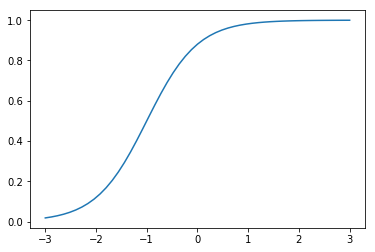

In [26]:
linear_input_unit = TransferMechanism(function=Linear(slope=2, intercept=2))
logistic_output_unit = TransferMechanism(function=Logistic())
mini_connected_network = process(
    pathway=[linear_input_unit, IDENTITY_MATRIX, logistic_output_unit])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = mini_connected_network.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

IDENTITY_MATRIX is a keyword that provides a projection from the unit preceding it to the unit following that creates a one-to-one output to input projection between the two. Other useful projection keywords are...

Now let's make our projection definition a bit more explicit.


'TransferMechanism-7'  executed:
- input:  -3.0
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -4.0

'TransferMechanism-8'  executed:
- input:  -4.0
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.018
-
'TransferMechanism-7'  executed:
- input:  -2.88
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.76



'TransferMechanism-8'  executed:
- input:  -3.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0228
-
'TransferMechanism-7'  executed:
- input:  -2.76
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.52

'TransferMechanism-8'  executed:
- input:  -3.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0287
-
'TransferMechanism-7'  executed:
- input:  -2.64
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0


	time_scale: TimeScale.TRIAL
- output: -3.28

'TransferMechanism-8'  executed:
- input:  -3.28
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0363
-
'TransferMechanism-7'  executed:
- input:  -2.52
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -3.04

'TransferMechanism-8'  executed:
- input:  -3.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0457
-
'TransferMechanism-7'  executed:
- input:  -2.4
- params:


	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.8

'TransferMechanism-8'  executed:
- input:  -2.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0573
-
'TransferMechanism-7'  executed:
- input:  -2.28
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.56

'TransferMechanism-8'  executed:
- input:  -2.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0718
-
'TransferMechanism-7'  executed:
- input:  -2.16
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0


	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.32

'TransferMechanism-8'  executed:
- input:  -2.32
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0895
-
'TransferMechanism-7'  executed:
- input:  -2.04
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -2.08

'TransferMechanism-8'  executed:
- input:  -2.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.111
-


'TransferMechanism-7'  executed:
- input:  -1.92
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.84



'TransferMechanism-8'  executed:
- input:  -1.84
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.137
-


'TransferMechanism-7'  executed:
- input:  -1.8
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.6



'TransferMechanism-8'  executed:
- input:  -1.6
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.168
-
'TransferMechanism-7'  executed:
- input:  -1.68


- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.36

'TransferMechanism-8'  executed:
- input:  -1.36
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.204
-
'TransferMechanism-7'  executed:
- input:  -1.56
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -1.12

'TransferMechanism-8'  executed:
- input:  -1.12
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.246
-
'TransferMechanism-7'  executed:
- input:  -1.44
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.88



'TransferMechanism-8'  executed:
- input:  -0.88
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.293
-
'TransferMechanism-7'  executed:
- input:  -1.32
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.64

'TransferMechanism-8'  executed:
- input:  -0.64
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.345
-
'TransferMechanism-7'  executed:
- input:  -1.2
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.4

'TransferMechanism-8'  executed:
- input:  -0.4
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.401
-


'TransferMechanism-7'  executed:
- input:  -1.08
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: -0.16

'TransferMechanism-8'  executed:
- input:  -0.16
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.46
-
'TransferMechanism-7'  executed:
- input:  -0.96
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.08

'TransferMechanism-8'  executed:
- input:  0.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.52
-
'TransferMechanism-7'  executed:
- input:  -0.84
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.32



'TransferMechanism-8'  executed:
- input:  0.32
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.579
-
'TransferMechanism-7'  executed:
- input:  -0.72
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.56

'TransferMechanism-8'  executed:
- input:  0.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.636
-
'TransferMechanism-7'  executed:
- input:  -0.6
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.8

'TransferMechanism-8'  executed:
- input:  0.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.69
-


'TransferMechanism-7'  executed:
- input:  -0.48
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.04

'TransferMechanism-8'  executed:
- input:  1.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.739
-
'TransferMechanism-7'  executed:
- input:  -0.36
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.28

'TransferMechanism-8'  executed:
- input:  1.28
- params:
	function: Logistic
		bias: 0.0


		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.782
-
'TransferMechanism-7'  executed:
- input:  -0.24
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.52

'TransferMechanism-8'  executed:
- input:  1.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.821
-
'TransferMechanism-7'  executed:
- input:  -0.12
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.76

'TransferMechanism-8'  executed:
- input:  1.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.853
-


'TransferMechanism-7'  executed:
- input:  0.0
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.0

'TransferMechanism-8'  executed:
- input:  2.0
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.881
-
'TransferMechanism-7'  executed:
- input:  0.12
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.24

'TransferMechanism-8'  executed:
- input:  2.24
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.904
-


'TransferMechanism-7'  executed:
- input:  0.24
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.48

'TransferMechanism-8'  executed:
- input:  2.48
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.923
-
'TransferMechanism-7'  executed:
- input:  0.36
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.72

'TransferMechanism-8'  executed:
- input:  2.72
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.938
-
'TransferMechanism-7'  executed:
- input:  0.48
- params:
	function: Linear


		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 2.96

'TransferMechanism-8'  executed:
- input:  2.96
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.951
-
'TransferMechanism-7'  executed:
- input:  0.6
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.2

'TransferMechanism-8'  executed:
- input:  3.2
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.961
-
'TransferMechanism-7'  executed:
- input:  0.72
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.44

'TransferMechanism-8'  executed:
- input:  3.44
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.969
-
'TransferMe

		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.68

'TransferMechanism-8'  executed:
- input:  3.68
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.975
-
'TransferMechanism-7'  executed:
- input:  0.96
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 3.92

'TransferMechanism-8'  executed:
- input:  3.92
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.981
-
'TransferMechanism-7'  executed:
- input:  1.08
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.16

'TransferMechanism-8'  executed:
- input:  4.16
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.985
-


'TransferMechanism-7'  executed:
- input:  1.2
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.4

'TransferMechanism-8'  executed:
- input:  4.4
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.988
-
'TransferMechanism-7'  executed:
- input:  1.32
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.64

'TransferMechanism-8'  executed:
- input:  4.64
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.99
-


'TransferMechanism-7'  executed:
- input:  1.44
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.88

'TransferMechanism-8'  executed:
- input:  4.88
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.992
-
'TransferMechanism-7'  executed:
- input:  1.56
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.12

'TransferMechanism-8'  executed:
- input:  5.12


- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.994
-
'TransferMechanism-7'  executed:
- input:  1.68
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.36

'TransferMechanism-8'  executed:
- input:  5.36
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.995
-
'TransferMechanism-7'  executed:
- input:  1.8
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.6

'TransferMechanism-8'  executed:
- input:  5.6
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.996
-


'TransferMechanism-7'  executed:
- input:  1.92
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 5.84

'TransferMechanism-8'  executed:
- input:  5.84
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.997
-
'TransferMechanism-7'  executed:
- input:  2.04
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.08

'TransferMechanism-8'  executed:
- input:  6.08
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.998
-


'TransferMechanism-7'  executed:
- input:  2.16
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.32

'TransferMechanism-8'  executed:
- input:  6.32
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.998
-
'TransferMechanism-7'  executed:
- input:  2.28
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.56

'TransferMechanism-8'  executed:
- input:  6.56
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-7'  executed:
- input:  2.4
- params:
	function: Linear
		intercept: 2
		slope: 2


	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 6.8

'TransferMechanism-8'  executed:
- input:  6.8
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-7'  executed:
- input:  2.52
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.04

'TransferMechanism-8'  executed:
- input:  7.04
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-7'  executed:
- input:  2.64
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.28

'TransferMechanism-8'  executed:
- input:  7.28


- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-7'  executed:
- input:  2.76
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.52

'TransferMechanism-8'  executed:
- input:  7.52
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.999
-
'TransferMechanism-7'  executed:
- input:  2.88
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 7.76

'TransferMechanism-8'  executed:
- input:  7.76
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0


	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0
-
'TransferMechanism-7'  executed:
- input:  3.0
- params:
	function: Linear
		intercept: 2
		slope: 2
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 8.0

'TransferMechanism-8'  executed:
- input:  8.0
- params:
	function: Logistic
		bias: 0.0
		gain: 1.0
	initial_value: 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0
-

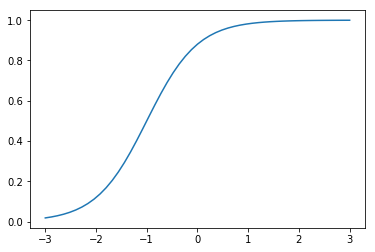

In [29]:
linear_input_unit = TransferMechanism(function=Linear(slope=2, intercept=2))
logistic_output_unit = TransferMechanism(function=Logistic())

mapping_matrix = np.asarray([[1]])
unit_mapping_projection = MappingProjection(sender=linear_input_unit,
                                            receiver=logistic_output_unit,
                                            matrix=mapping_matrix)
mini_connected_network = process(
    pathway=[linear_input_unit, unit_mapping_projection, logistic_output_unit])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = mini_connected_network.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

This time we specified our mapping matrix (which is a 2-D numpy array) then explicitly initialized a *[MappingProjection](https://princetonuniversity.github.io/PsyNeuLink/MappingProjection.html)* with that matrix as well as its input and output mechanisms. Note: because we specified the input and output mechanisms in the projection itself, we didn't need to include it in the process pathway as it will infer its position from those parameters. Ultimately, however, this does the exact same thing as our keyword method above which is far less verbose for this common use case.

### Systems

The highest level at which models are considered in PsyNeuLink is that of the *[System](https://princetonuniversity.github.io/PsyNeuLink/System.html)*. A system is composed of one or more processes which can then run in unison. This allows system graphs to be more complex than the strictly linear ones of processes. Our first system will consist of two input nodes that converge on a single output mechanism. We will be modelling competition between color naming and word reading in the stroop task.

In [3]:
colors = TransferMechanism(default_input_value=[0, 0], function=Linear,
                           name="Colors")
words = TransferMechanism(default_input_value=[0, 0],
                          function=Linear(slope=1.5), name="Words")
response = TransferMechanism(default_input_value=[0, 0], function=Logistic,
                             name="Response")

color_naming_process = process(pathway=[colors, IDENTITY_MATRIX, response],
                               name="Color Naming")
word_reading_process = process(pathway=[words, IDENTITY_MATRIX, response],
                               name="Word Reading")

# Should pass in scheduler or have system create new scheduler if scheduler=None
mini_stroop = system(processes=[color_naming_process, word_reading_process],
                     name='Stroop Model')

# Note: Once again, make sure you do not run this cell multiple times. This would create multiple
# processes and systems that share the same variable name in the PsyNeuLink registry causing
# unexpected behavior.

The order of processes in the system initialization is important here as it is the order we will feed inputs to the system.

In [12]:
input = {colors: [1, 0], 
         words: [0, 1]}
mini_stroop.run(input)3

[[array([ 0.73105858,  0.81757448])], [array([ 0.73105858,  0.81757448])]]

In [15]:
input_dict = {colors: [0, 1],
              words: [0, 1]}
mini_stroop.run(input_dict)

[[array([ 0.73105858,  0.81757448])],
 [array([ 0.73105858,  0.81757448])],
 [array([ 0.5       ,  0.92414182])]]

As modeled, we see that word reading beats out color naming when there is conflict, but congruent stimuli elicit an even stronger response.

### Pre-trained Complete Stroop Model

Let's practice using systems by recreating the more complex stroop model from Cohen et al (1990). Later we will train the network ourselves, but for now we will explicitly model the learned weights.

In [16]:
ink_color = TransferMechanism(default_input_value=[0, 0], function=Linear())
word = TransferMechanism(default_input_value=[0, 0], function=Linear())
task_demand = TransferMechanism(default_input_value=[0, 0], function=Linear())

hidden_layer = TransferMechanism(default_input_value=[0, 0, 0, 0],
                                 function=Logistic(bias=-4))

output_layer = TransferMechanism(default_input_value=[0, 0], function=Linear())

color_mapping_matrix = np.asarray([[2.2, -2.2, 0, 0], [-2.2, 2.2, 0, 0]])
color_projection = MappingProjection(sender=ink_color, receiver=hidden_layer,
                                     matrix=color_mapping_matrix)
word_mapping_matrix = np.asarray([[0, 0, 2.6, -2.6], [0, 0, -2.6, 2.6]])
word_projection = MappingProjection(sender=word, receiver=hidden_layer,
                                    matrix=word_mapping_matrix)
task_mapping_matrix = np.asarray([[4, 4, 0, 0], [0, 0, 4, 4]])
task_projection = MappingProjection(sender=task_demand, receiver=hidden_layer,
                                    matrix=task_mapping_matrix)
output_mapping_matrix = np.asarray(
    [[1.3, -1.3], [-1.3, 1.3], [2.5, -2.5], [-2.5, 2.5]])
MappingProjection(sender=hidden_layer, receiver=output_layer,
                  matrix=output_mapping_matrix)

color_naming_process = process(pathway=[ink_color, hidden_layer, output_layer])
word_reading_process = process(pathway=[word, hidden_layer, output_layer])
task_process = process(pathway=[task_demand, hidden_layer, output_layer])

stroop_model = system(
    processes=[color_naming_process, word_reading_process, task_process])

ink_color.reportOutputPref = True
word.reportOutputPref = True
task_demand.reportOutputPref = True
hidden_layer.reportOutputPref = True

# Note: Once again, make sure you do not run this cell multiple times. This would create multiple
# processes and systems that share the same variable name in the PsyNeuLink registry causing
# unexpected behavior.

In [17]:
input_dict = {ink_color: [1, 0],
              word: [1, 0],
              task_demand: [0, 1]}
stroop_model.run(input_dict)


'TransferMechanism-1'  executed:
- input:  1.0, 0.0
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0 0.0

'TransferMechanism-3'  executed:
- input:  0.0, 1.0
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0 1.0

'TransferMechanism-2'  executed:
- input:  1.0, 0.0
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0 0.0

'TransferMechanism-4'  executed:
- input:  2.2, -2.2, 6.6, 1.4
- params:
	function: Logistic
		bias: -4
		gain: 1.0
	initial_value: 0 0 0 0
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.998 0.858 1.0 0.996


[[array([ 0.19295186, -0.19295186])]]

This is currently the end of the tutorial, but more content is being added weekly. For further examples, look to the Scripts folder inside your PsyNeuLink directory for several functioning models.